In [135]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Step 1: Data Preparation

In [136]:
species_mapping = pd.read_csv("species_percentage.csv")
species_mapping = species_mapping[species_mapping['Percentage'] >= 80]

# data_dir = 'D:/Yehmh/test_py/202301/P00074_transect_1/1m_1m/known'
# Folder_names = "T1S"
# image_size = 34

data_dir = 'D:/Yehmh/test_py/202301/P00073_transect_234/10m_10m/known'
Folder_names = "T"

X = []  # Features
y = []  # Labels

for folder in os.listdir(data_dir):
    if folder.startswith(Folder_names):
        species_info = species_mapping.loc[species_mapping["Plot"] == folder]
        if not species_info.empty and not pd.isna(species_info["SpeciesID"].values[0]):
            species = species_info["SpeciesID"].values[0]
            for file in os.listdir(os.path.join(data_dir, folder)):
                if file.endswith(".tif"):
                    image_path = os.path.join(data_dir, folder, file)
                    image = cv2.imread(image_path)
                    if image.shape[0] > 64:
                        image = cv2.resize(image, (64, 64))  # Resize image if necessary
                    else:
                        print("image size: ", image.shape)
                    
                    X.append(image)
                    y.append(species)
        else:
            print(f"Folder {folder} does not have a corresponding species label.")

Folder T2S9 does not have a corresponding species label.
Folder T4S1 does not have a corresponding species label.
Folder T4S4 does not have a corresponding species label.


## Step 2: Data Preprocessing

In [137]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
print(label_encoder.classes_)
print(y)
print(len(X_train), len(X_test))

[2 4 5 6]
[3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
66 17


## Step 3: Define transformations and create datasets

In [139]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image data
])

train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

## Step 4: Create data loaders

In [140]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test_loader is created with shuffle=False. 
# Ensures that the evaluation process remains consistent across different evaluations 
# and that the model is tested on the same data distribution every time

## Step 5: Define the CNN model

In [141]:
print(image.shape)

(64, 64, 3)


In [142]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # (in_channels (rgb), out_channels, filter_num, stride, padding), default stride = 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Define the forward pass through the network
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        # x = x.view(-1, 64 * 16 * 16)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Step 6: Initialize model. loss function, and optimizer

In [143]:
model = CNN(num_classes=len(label_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [144]:
print(len(label_encoder.classes_))

4


## Step 7: Train the model

In [145]:
def accuracy(predictions, laels):
    pred = torch.max(prediction.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [146]:
# num_epochs = 5000
# for epoch in range(num_epochs):
#     model.train()
#     for images, labels in train_loader:
#         # print("Batch Shape - Images:", images.shape)
#         # print("Batch Shape - Labels:", labels.shape)

#         optimizer.zero_grad()   # Zero the gradient
#         outputs = model(images) # Forward pass: computer predicted outputs
#         # print(outputs.shape)
#         loss = criterion(outputs, labels) # Compute the loss
#         loss.backward()     # Backward pass: compute gradient of the loss with respect to model parameters
#         optimizer.step()    # Update the model parameters based on the gradients

#     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/60], Loss: 1.1962983012199402, Accuracy: 0.48484848484848486
Epoch [2/60], Loss: 1.4741946458816528, Accuracy: 0.48484848484848486
Epoch [3/60], Loss: 1.1787973642349243, Accuracy: 0.48484848484848486
Epoch [4/60], Loss: 1.1920057932535808, Accuracy: 0.3939393939393939
Epoch [5/60], Loss: 1.1888694365819295, Accuracy: 0.19696969696969696
Epoch [6/60], Loss: 1.1794519821802776, Accuracy: 0.19696969696969696
Epoch [7/60], Loss: 1.2124134302139282, Accuracy: 0.19696969696969696
Epoch [8/60], Loss: 1.1179306507110596, Accuracy: 0.36363636363636365
Epoch [9/60], Loss: 1.1132258971532185, Accuracy: 0.6666666666666666
Epoch [10/60], Loss: 1.0187283754348755, Accuracy: 0.48484848484848486
Epoch [11/60], Loss: 1.5213295420010884, Accuracy: 0.48484848484848486
Epoch [12/60], Loss: 0.8895341157913208, Accuracy: 0.6666666666666666
Epoch [13/60], Loss: 1.0165470441182454, Accuracy: 0.6212121212121212
Epoch [14/60], Loss: 0.8422277967135111, Accuracy: 0.6818181818181818
Epoch [15/60], Loss:

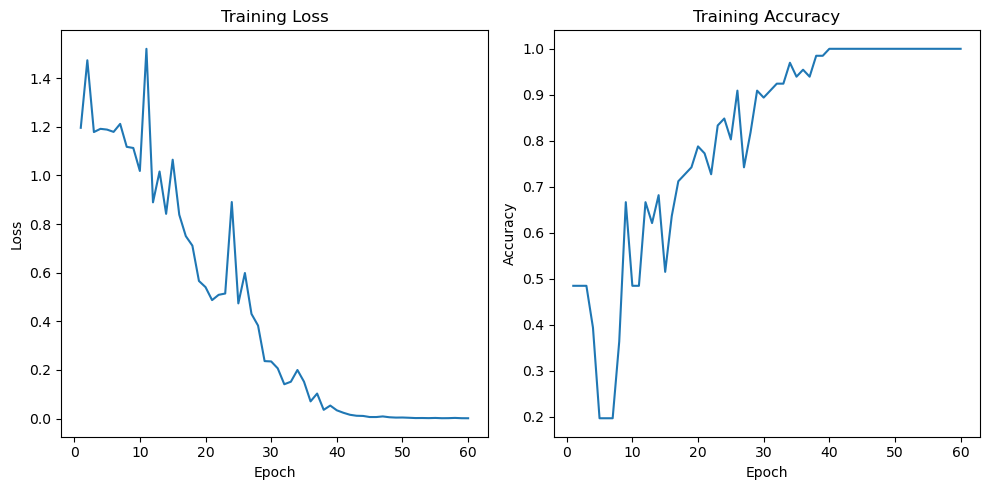

In [147]:
import matplotlib.pyplot as plt

num_epochs = 60
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    epoch_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()   # Zero the gradient
        outputs = model(images) # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward()     # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()    # Update the model parameters based on the gradients
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss += loss.item()

    train_accuracy = correct / total
    train_loss = epoch_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}")

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()


## Step 8: Evaluate the model

In [148]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

Test Accuracy: 82.35%
